# Data Preparation

In [1]:
# ===============================
# CELL 0 — Environment Setup
# ===============================

import os
import numpy as np
import tensorflow as tf
from pathlib import Path

print("TensorFlow Version:", tf.__version__)

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# Image parameters
IMG_SIZE   = 224
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

# Kaggle working paths
WORK_DIR   = "/kaggle/working"
DATA_DIR   = f"{WORK_DIR}/dataset"
SPLIT_DIR  = f"{WORK_DIR}/split"
MODEL_DIR  = f"{WORK_DIR}/models"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(SPLIT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

print("Folders created:")
print(DATA_DIR)
print(SPLIT_DIR)
print(MODEL_DIR)
import shutil
from pathlib import Path
from PIL import Image

# Dataset input paths (Kaggle)
HAM_ROOT = "/kaggle/input/skin-cancer-mnist-ham10000"

MERGED_DIR = Path(DATA_DIR)
shutil.rmtree(MERGED_DIR, ignore_errors=True)
MERGED_DIR.mkdir(parents=True, exist_ok=True)

VALID_EXT = {".jpg", ".jpeg", ".png", ".bmp"}

def is_image(p):
    return p.suffix.lower() in VALID_EXT

def safe_copy(src, dst):
    try:
        with Image.open(src) as img:
            img = img.convert("RGB")
            img.save(dst, format="JPEG", quality=92)
        return True
    except:
        return False

# -------------------------------
# 1A. Merge HAM10000
# -------------------------------
import pandas as pd

def merge_ham():
    meta = Path(HAM_ROOT) / "HAM10000_metadata.csv"
    img1 = Path(HAM_ROOT) / "HAM10000_images_part_1"
    img2 = Path(HAM_ROOT) / "HAM10000_images_part_2"

    df = pd.read_csv(meta)
    count = 0

    for _, row in df.iterrows():
        img_id = row["image_id"]
        label  = row["dx"].lower()

        src = img1 / f"{img_id}.jpg"
        if not src.exists():
            src = img2 / f"{img_id}.jpg"

        if src.exists():
            dst_dir = MERGED_DIR / label
            dst_dir.mkdir(exist_ok=True)
            ok = safe_copy(src, dst_dir / f"ham_{img_id}.jpg")
            if ok:
                count += 1

    print("HAM images copied:", count)


# Run merge
merge_ham()

# Report dataset summary
summary = {d.name: len(list(d.glob("*.jpg"))) 
           for d in MERGED_DIR.iterdir() if d.is_dir()}
print("\nFinal Dataset Summary:")
for k,v in summary.items():
    print(f"{k:20s} : {v}")
import shutil
from pathlib import Path

RAW_DIR = Path(DATA_DIR)
CLEAN_DIR = Path(f"{WORK_DIR}/dataset_clean")

shutil.rmtree(CLEAN_DIR, ignore_errors=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# Label mapping
LABEL_MAP = {
    "akiec": "akiec",
    "bcc": "bcc",
    "bkl": "bkl",
    "df": "df",
    "mel": "mel",
    "nv": "nv",
    "vasc": "vasc"
}

# ===============================
# CELL 3 — Stratified Split
# ===============================

from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
import numpy as np

CLEAN_DIR = Path(DATA_DIR)
SPLIT_DIR = Path(f"{WORK_DIR}/split")

# Reset split directory
shutil.rmtree(SPLIT_DIR, ignore_errors=True)
(SPLIT_DIR / "train").mkdir(parents=True, exist_ok=True)
(SPLIT_DIR / "val").mkdir(parents=True, exist_ok=True)
(SPLIT_DIR / "test").mkdir(parents=True, exist_ok=True)

# Collect all image paths + labels
X = []
y = []

for cls_dir in sorted(CLEAN_DIR.iterdir()):
    if not cls_dir.is_dir():
        continue
    for img in cls_dir.glob("*.jpg"):
        X.append(str(img))
        y.append(cls_dir.name)

X = np.array(X)
y = np.array(y)

print("Total images:", len(X))
print("Classes:", sorted(set(y)))

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=SEED
)

# Split temp → 15% val, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
)

def copy_split(Xs, Ys, split_name):
    for path, label in zip(Xs, Ys):
        dst = SPLIT_DIR / split_name / label
        dst.mkdir(parents=True, exist_ok=True)
        shutil.copy(path, dst / Path(path).name)

copy_split(X_train, y_train, "train")
copy_split(X_val,   y_val,   "val")
copy_split(X_test,  y_test,  "test")

# Report distribution
def report_counts(split):
    print(f"\n📂 {split.upper()} distribution:")
    base = SPLIT_DIR / split
    for cls in sorted(base.iterdir()):
        if cls.is_dir():
            print(f"{cls.name:15s} : {len(list(cls.glob('*.jpg')))}")

report_counts("train")
report_counts("val")
report_counts("test")

print("\n✅ Stratified split completed successfully.")
# ===============================
# CELL 4 — tf.data Pipeline + Augmentation
# ===============================

from tensorflow import keras
from keras import layers

CLASS_NAMES = sorted([d.name for d in (SPLIT_DIR / "train").iterdir() if d.is_dir()])
NUM_CLASSES = len(CLASS_NAMES)

print("Classes:", CLASS_NAMES)
print("Total classes:", NUM_CLASSES)

# ------------------------
# Dataset Loader Function
# ------------------------
def build_dataset(split, augment=False, shuffle=False):
    ds = keras.utils.image_dataset_from_directory(
        directory = SPLIT_DIR / split,
        labels="inferred",
        label_mode="int",         # IMPORTANT → integer labels
        class_names=CLASS_NAMES,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        seed=SEED
    )

    # Normalize 0–1
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),
                num_parallel_calls=AUTOTUNE)

    # Data Augmentation (train only)
    if augment:
        augmenter = keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.08),
            layers.RandomZoom(0.10),
            layers.RandomContrast(0.10),
        ])
        ds = ds.map(lambda x, y: (augmenter(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(AUTOTUNE)


# Build datasets
train_ds = build_dataset("train", augment=False,  shuffle=True) # change for next rerun after CNN BenchMarking
val_ds   = build_dataset("val",   augment=False, shuffle=False)
test_ds  = build_dataset("test",  augment=False, shuffle=False)

print("\n✅ Datasets ready for training.")
# ===============================
# CELL 5 — Class Weights
# ===============================

from collections import Counter

train_path = SPLIT_DIR / "train"

counts = Counter()
for cls in CLASS_NAMES:
    counts[cls] = len(list((train_path / cls).glob("*")))

total = sum(counts.values())
print("Training distribution:")
for k, v in counts.items():
    print(f"{k:12s} : {v}")

# Balanced weighting formula (stable
class_weights = {}
for idx, cls in enumerate(CLASS_NAMES):
    freq = counts[cls] / total
    class_weights[idx] = float(1.0 / np.sqrt(freq))

print("\nComputed Class Weights:")
for k, v in class_weights.items():
    print(f"{CLASS_NAMES[k]:12s} → {round(v,3)}")

2026-02-07 05:53:35.929526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770443616.147610      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770443616.211985      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770443616.733639      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770443616.733679      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770443616.733681      55 computation_placer.cc:177] computation placer alr

TensorFlow Version: 2.19.0
Folders created:
/kaggle/working/dataset
/kaggle/working/split
/kaggle/working/models
HAM images copied: 10015

Final Dataset Summary:
bkl                  : 1099
vasc                 : 142
df                   : 115
bcc                  : 514
akiec                : 327
nv                   : 6705
mel                  : 1113
Total images: 10015
Classes: [np.str_('akiec'), np.str_('bcc'), np.str_('bkl'), np.str_('df'), np.str_('mel'), np.str_('nv'), np.str_('vasc')]

📂 TRAIN distribution:
akiec           : 229
bcc             : 360
bkl             : 769
df              : 81
mel             : 779
nv              : 4693
vasc            : 99

📂 VAL distribution:
akiec           : 49
bcc             : 77
bkl             : 165
df              : 17
mel             : 167
nv              : 1006
vasc            : 21

📂 TEST distribution:
akiec           : 49
bcc             : 77
bkl             : 165
df              : 17
mel             : 167
nv              : 1006
vas

I0000 00:00:1770443790.717624      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770443790.723674      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1502 files belonging to 7 classes.
Found 1503 files belonging to 7 classes.

✅ Datasets ready for training.
Training distribution:
akiec        : 229
bcc          : 360
bkl          : 769
df           : 81
mel          : 779
nv           : 4693
vasc         : 99

Computed Class Weights:
akiec        → 5.533
bcc          → 4.413
bkl          → 3.019
df           → 9.303
mel          → 3.0
nv           → 1.222
vasc         → 8.415


# CNN BenchMarking

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, classification_report
import numpy as np
import pandas as pd

# Mixed precision (speedup on GPU)
tf.keras.mixed_precision.set_global_policy("mixed_float16")

NUM_CLASSES = 7
EPOCHS_HEAD = 5
EPOCHS_FINE = 15
LR_HEAD = 1e-4
LR_FINE = 1e-5

In [4]:
def evaluate_model(model, dataset, split_name):
    y_true, y_pred = [], []

    for x, y in dataset:
        preds = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(y.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_true == y_pred)
    f1  = f1_score(y_true, y_pred, average="macro")

    print(f"\n📊 {split_name} Metrics")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Macro F1  : {f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    return acc, f1
def build_cnn(backbone, name):
    inputs = keras.Input(shape=(224,224,3))

    x = backbone(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(
        NUM_CLASSES,
        activation="softmax",
        dtype="float32"   # IMPORTANT for mixed precision
    )(x)

    model = keras.Model(inputs, outputs, name=name)
    return model
def train_and_evaluate(model, backbone):

    # ---- PHASE 1: Head training ----
    backbone.trainable = False
    model.compile(
        optimizer=keras.optimizers.Adam(LR_HEAD),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print(f"\n🚀 Training head: {model.name}")
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_HEAD,
        class_weight=class_weights,
        verbose=1
    )

    # ---- PHASE 2: Fine-tuning ----
    backbone.trainable = True
    for layer in backbone.layers[:int(0.6 * len(backbone.layers))]:
        layer.trainable = False

    model.compile(
        optimizer=keras.optimizers.Adam(LR_FINE),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    print(f"\n🔧 Fine-tuning: {model.name}")
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_FINE,
        class_weight=class_weights,
        verbose=1
    )

    # ---- Evaluation ----
    train_acc, train_f1 = evaluate_model(model, train_ds, "TRAIN")
    val_acc, val_f1     = evaluate_model(model, val_ds,   "VAL")
    test_acc, test_f1   = evaluate_model(model, test_ds,  "TEST")

    return {
        "Model": model.name,
        "Train_Acc": train_acc,
        "Train_F1": train_f1,
        "Val_Acc": val_acc,
        "Val_F1": val_f1,
        "Test_Acc": test_acc,
        "Test_F1": test_f1
    }


**DenseNet 121**

In [5]:
backbone = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model = build_cnn(backbone, "DenseNet121")
results_densenet = train_and_evaluate(model, backbone)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training head: DenseNet121
Epoch 1/5


I0000 00:00:1770443920.760971     150 service.cc:152] XLA service 0x7cfcb00228b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770443920.761016     150 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770443920.761021     150 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770443924.551272     150 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/220 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.0486 - loss: 4.7962     

I0000 00:00:1770443938.897424     150 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 79s 220ms/step - accuracy: 0.3297 - loss: 4.2942 - val_accuracy: 0.6531 - val_loss: 1.1281
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6191 - loss: 2.9738 - val_accuracy: 0.6924 - val_loss: 0.9110
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6657 - loss: 2.5118 - val_accuracy: 0.7130 - val_loss: 0.8334
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.6932 - loss: 2.3352 - val_accuracy: 0.7290 - val_loss: 0.7972
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.7061 - loss: 2.1807 - val_accuracy: 0.7337 - val_loss: 0.7688

🔧 Fine-tuning: DenseNet121
Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 212s 463ms/step - accuracy: 0.6707 - loss: 2.6369 - val_accuracy: 0.7244 - val_loss: 0.7677
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.6968 - loss: 2.2433 - val_accuracy: 0.7244 - val_loss: 0.7628
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.7165 -

**EfficientNetB0**

In [6]:
backbone = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

model = build_cnn(backbone, "EfficientNetB0")
results_effb0 = train_and_evaluate(model, backbone)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training head: EfficientNetB0
Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 132s 366ms/step - accuracy: 0.5175 - loss: 4.0955 - val_accuracy: 0.6698 - val_loss: 1.7755
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6019 - loss: 3.9103 - val_accuracy: 0.6698 - val_loss: 1.8222
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6144 - loss: 3.8963 - val_accuracy: 0.6698 - val_loss: 1.6963
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6123 - loss: 3.8837 - val_accuracy: 0.6698 - val_loss: 1.6643
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6378 - loss: 3.8021 - val_accuracy: 0.6698 - val_loss: 1.6267

🔧 Fine-tuning: EfficientNetB0
Epoch 1/15


2026-02-07 06:12:08.235673: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:12:08.375493: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:12:15.757959: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:12:15.914460: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:12:16.091095: E external/local_xla/xla/stream_

218/220 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4624 - loss: 4.8514

2026-02-07 06:13:12.989966: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:13:13.145313: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:13:13.278785: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:13:20.562593: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:13:20.714035: E external/local_xla/xla/stream_

220/220 ━━━━━━━━━━━━━━━━━━━━ 170s 405ms/step - accuracy: 0.4626 - loss: 4.8474 - val_accuracy: 0.6698 - val_loss: 1.1786
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.4972 - loss: 4.4487 - val_accuracy: 0.6671 - val_loss: 1.2818
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5130 - loss: 4.2219 - val_accuracy: 0.6664 - val_loss: 1.2392
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5091 - loss: 4.1234 - val_accuracy: 0.6671 - val_loss: 1.2545
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5183 - loss: 3.9818 - val_accuracy: 0.6671 - val_loss: 1.3186
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.5193 - loss: 3.9707 - val_accuracy: 0.6678 - val_loss: 1.3319
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5295 - loss: 3.9761 - val_accuracy: 0.6671 - val_loss: 1.1965
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5335 - loss: 3.9221 - val_accuracy: 0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 VAL Metrics
Accuracy  : 0.6678
Macro F1  : 0.1252
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.32      0.04      0.07       165
          df       0.00      0.00      0.00        17
         mel       0.00      0.00      0.00       167
          nv       0.67      0.99      0.80      1006
        vasc       0.00      0.00      0.00        21

    accuracy                           0.67      1502
   macro avg       0.14      0.15      0.13      1502
weighted avg       0.49      0.67      0.54      1502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 TEST Metrics
Accuracy  : 0.6700
Macro F1  : 0.1242
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.00      0.00      0.00        77
         bkl       0.25      0.04      0.06       165
          df       0.00      0.00      0.00        17
         mel       0.00      0.00      0.00       167
          nv       0.68      1.00      0.81      1006
        vasc       0.00      0.00      0.00        22

    accuracy                           0.67      1503
   macro avg       0.13      0.15      0.12      1503
weighted avg       0.48      0.67      0.55      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**EfficientNet B3**

In [7]:
backbone = keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
n
model = build_cnn(backbone, "EfficientNetB3")
results_effb3 = train_and_evaluate(model, backbone)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🚀 Training head: EfficientNetB3
Epoch 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 183s 504ms/step - accuracy: 0.4520 - loss: 4.2820 - val_accuracy: 0.6438 - val_loss: 1.8721
Epoch 2/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5402 - loss: 3.9845 - val_accuracy: 0.6465 - val_loss: 1.7185
Epoch 3/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5579 - loss: 3.9386 - val_accuracy: 0.6411 - val_loss: 1.5941
Epoch 4/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.5801 - loss: 3.8597 - val_accuracy: 0.6431 - val_loss: 1.4938
Epoch 5/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.5703 - loss: 3.8770 - val_accuracy: 0.6558 - val_loss: 1.4689

🔧 Fine-tuning: EfficientNetB3
Epoch 1/15


2026-02-07 06:22:48.198452: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:22:48.349292: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:22:56.052312: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:22:56.214450: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:22:56.407652: E external/local_xla/xla/stream_

219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4024 - loss: 4.8107

2026-02-07 06:24:28.826700: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:24:28.972362: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:24:29.108038: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:24:36.503404: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-07 06:24:36.667722: E external/local_xla/xla/stream_

220/220 ━━━━━━━━━━━━━━━━━━━━ 256s 604ms/step - accuracy: 0.4026 - loss: 4.8093 - val_accuracy: 0.6431 - val_loss: 1.3889
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.4436 - loss: 4.5813 - val_accuracy: 0.6571 - val_loss: 1.1439
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.4492 - loss: 4.4605 - val_accuracy: 0.6611 - val_loss: 1.2176
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.4565 - loss: 4.4693 - val_accuracy: 0.6551 - val_loss: 1.2602
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4826 - loss: 4.4183 - val_accuracy: 0.6531 - val_loss: 1.1868
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4696 - loss: 4.2491 - val_accuracy: 0.6591 - val_loss: 1.1657
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4667 - loss: 4.2582 - val_accuracy: 0.6578 - val_loss: 1.1186
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.4911 - loss: 4.1197 - val_accur

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 VAL Metrics
Accuracy  : 0.6505
Macro F1  : 0.1319
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        49
         bcc       0.11      0.13      0.12        77
         bkl       0.00      0.00      0.00       165
          df       0.00      0.00      0.00        17
         mel       0.00      0.00      0.00       167
          nv       0.69      0.96      0.80      1006
        vasc       0.00      0.00      0.00        21

    accuracy                           0.65      1502
   macro avg       0.11      0.16      0.13      1502
weighted avg       0.47      0.65      0.54      1502



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 TEST Metrics
Accuracy  : 0.6487
Macro F1  : 0.1476
              precision    recall  f1-score   support

       akiec       0.17      0.04      0.07        49
         bcc       0.14      0.17      0.16        77
         bkl       0.00      0.00      0.00       165
          df       0.00      0.00      0.00        17
         mel       0.50      0.01      0.01       167
          nv       0.69      0.95      0.80      1006
        vasc       0.00      0.00      0.00        22

    accuracy                           0.65      1503
   macro avg       0.21      0.17      0.15      1503
weighted avg       0.53      0.65      0.55      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Custom CNN**

In [10]:
def custom_cnn():
    inputs = keras.Input(shape=(224,224,3))

    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)

    return keras.Model(inputs, outputs, name="CustomCNN")

model = custom_cnn()
model.compile(
    optimizer=keras.optimizers.Adam(LR_HEAD),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🚀 Training Custom CNN")
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    verbose=1
)

# Evaluate model once per split
train_loss, train_acc = evaluate_model(model, train_ds, "TRAIN")
val_loss, val_acc     = evaluate_model(model, val_ds,   "VAL")
test_loss, test_acc   = evaluate_model(model, test_ds,  "TEST")

# Store results
results_custom = {
    "Model": "CustomCNN",
    "Train_Acc": train_acc,
    "Val_Acc":   val_acc,
    "Test_Acc":  test_acc,
}




🚀 Training Custom CNN
Epoch 1/20


2026-02-07 06:35:29.528708: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv %cudnn-conv-bw-filter.5 = (f16[64,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,111,111,32]{3,2,1,0} %bitcast.5781, f16[32,109,109,64]{3,2,1,0} %bitcast.5806), window={size=3x3}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", metadata={op_type="Conv2DBackpropFilter" op_name="gradient_tape/CustomCNN_1/conv2d_1_2/convolution/Conv2DBackpropFilter" source_file="/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2026-02-07 06:35:37.009277: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 8.480982284s
Trying algorithm eng0{} fo

220/220 ━━━━━━━━━━━━━━━━━━━━ 34s 65ms/step - accuracy: 0.6113 - loss: 3.8908 - val_accuracy: 0.6698 - val_loss: 1.2742
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6515 - loss: 3.5853 - val_accuracy: 0.6698 - val_loss: 1.1351
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6319 - loss: 3.4804 - val_accuracy: 0.6691 - val_loss: 1.1270
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6314 - loss: 3.4171 - val_accuracy: 0.6671 - val_loss: 1.1008
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6213 - loss: 3.3624 - val_accuracy: 0.6518 - val_loss: 1.0659
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6106 - loss: 3.2917 - val_accuracy: 0.6411 - val_loss: 1.0526
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6104 - loss: 3.1553 - val_accuracy: 0.6471 - val_loss: 1.0317
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6145 - loss: 3.0892 - val_accuracy: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 TEST Metrics
Accuracy  : 0.6660
Macro F1  : 0.3314
              precision    recall  f1-score   support

       akiec       0.23      0.27      0.25        49
         bcc       0.37      0.44      0.40        77
         bkl       0.39      0.41      0.40       165
          df       0.00      0.00      0.00        17
         mel       0.34      0.41      0.37       167
          nv       0.84      0.81      0.82      1006
        vasc       0.25      0.05      0.08        22

    accuracy                           0.67      1503
   macro avg       0.35      0.34      0.33      1503
weighted avg       0.67      0.67      0.67      1503



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
df_results = pd.DataFrame([
    results_densenet,
    results_effb0,
    results_effb3,
    results_custom
])

df_results.sort_values("Val_F1", ascending=False)


,Model,Train_Acc,Train_F1,Val_Acc,Val_F1,Test_Acc,Test_F1
0,DenseNet121,0.968188,0.966928,0.797603,0.634600,0.786427,0.602919
2,EfficientNetB3,0.648645,0.147698,0.650466,0.131948,0.648703,0.147609
1,EfficientNetB0,0.669330,0.123138,0.667776,0.125165,0.669993,0.124161
3,CustomCNN,0.322689,NaN,0.321437,NaN,0.331352,NaN


In [31]:
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = 7

backbone = keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    name="densenet121"
)

inputs = keras.Input(shape=(224,224,3))
x = backbone(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(
    NUM_CLASSES,
    activation="softmax",
    dtype="float32"
)(x)

densenet_model = keras.Model(inputs, outputs, name="DenseNet121")
densenet_model.summary()


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,799 (27.87 MB)

 Trainable params: 7,220,103 (27.54 MB)

 Non-trainable params: 85,696 (334.75 KB)

In [33]:
SAVE_DIR = "/kaggle/working/models/densenet121"
os.makedirs(SAVE_DIR, exist_ok=True)

densenet_model.save(
    f"{SAVE_DIR}/densenet121_full.keras",
    include_optimizer=False
)

print("✅ DenseNet121 model saved correctly.")
loaded = keras.models.load_model(
    f"{SAVE_DIR}/densenet121_full.keras"
)

print("Loaded model:", loaded.name)


✅ DenseNet121 model saved correctly.
Loaded model: DenseNet121


# Feature Extraction

**CNN(DenseNet)+Transformer**

In [37]:
from tensorflow import keras

densenet_backbone = densenet_model.get_layer("densenet121")

print("Backbone name:", densenet_backbone.name)
print("Backbone output shape:", densenet_backbone.output_shape)
densenet_backbone.trainable = False

Backbone name: densenet121
Backbone output shape: (None, 7, 7, 1024)


In [53]:
import tensorflow as tf
from tensorflow.keras import layers

class SpatialPositionalEmbedding(layers.Layer):
    def __init__(self, num_tokens, embed_dim):
        super().__init__()
        self.pos_emb = self.add_weight(
            name="pos_embedding",
            shape=(1, num_tokens, embed_dim),
            initializer="random_normal",
            trainable=True
        )

    def call(self, x):
        return x + self.pos_emb


class CNNTokenizer(layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.proj = layers.Dense(embed_dim)

    def call(self, feature_map):
        # feature_map: [B, 7, 7, 1024]
        B = tf.shape(feature_map)[0]
        x = tf.reshape(feature_map, [B, 49, 1024])   # 7×7 = 49 tokens
        x = self.proj(x)                             # → [B, 49, D]
        return x


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()

        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim
        )
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()

        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
        ])
        self.dropout = layers.Dropout(dropout)

    def call(self, x, training=False):
        attn_out = self.attn(x, x)
        x = self.norm1(x + self.dropout(attn_out, training=training))
        mlp_out = self.mlp(x, training=training)
        return self.norm2(x + mlp_out)


def build_cnn_transformer_encoder(
    backbone,
    embed_dim=256,
    num_heads=4,
    mlp_dim=512,
    num_layers=2
):
    inputs = tf.keras.Input(shape=(224,224,3))

    # CNN backbone (FROZEN for now)
    backbone.trainable = False
    feature_map = backbone(inputs, training=False)  # (B,7,7,1024)

    # Tokenization
    tokens = CNNTokenizer(embed_dim)(feature_map)

    # Positional encoding
    tokens = SpatialPositionalEmbedding(49, embed_dim)(tokens)

    # Transformer stack
    for _ in range(num_layers):
        tokens = TransformerEncoder(
            embed_dim, num_heads, mlp_dim
        )(tokens)

    # Global avg pooling over tokens
    embedding = tf.keras.layers.GlobalAveragePooling1D()(tokens)


    return tf.keras.Model(inputs, embedding, name="CNN_Transformer_Encoder")


def build_cnn_transformer_encoder(
    backbone,
    embed_dim=256,
    num_heads=4,
    mlp_dim=512,
    num_layers=2
):
    inputs = tf.keras.Input(shape=(224,224,3))

    # CNN backbone (frozen)
    backbone.trainable = False
    feature_map = backbone(inputs, training=False)  # (B,7,7,1024)

    # Tokenization
    tokens = CNNTokenizer(embed_dim)(feature_map)   # (B,49,D)

    # Positional encoding
    tokens = SpatialPositionalEmbedding(49, embed_dim)(tokens)

    # Transformer encoder stack
    for _ in range(num_layers):
        tokens = TransformerEncoder(
            embed_dim=embed_dim,
            num_heads=num_heads,
            mlp_dim=mlp_dim
        )(tokens)

    # ✅ Keras-native token pooling
    embedding = tf.keras.layers.GlobalAveragePooling1D()(tokens)

    return tf.keras.Model(inputs, embedding, name="CNN_Transformer_Encoder")

In [54]:
cnn_transformer = build_cnn_transformer_encoder(
    backbone=densenet_backbone,
    embed_dim=256,
    num_heads=4,
    mlp_dim=512,
    num_layers=2
)

cnn_transformer.summary()

Model: "CNN_Transformer_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_tokenizer_4 (CNNTokenizer)  │ (None, 49, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_positional_embedding_4  │ (None, 49, 256)        │        12,544 │
│ (SpatialPositionalEmbedding)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_9           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,944,128 (37.93 MB)

 Trainable params: 2,906,624 (11.09 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [55]:
from tensorflow.keras import layers, Model

def add_mlp_head(encoder, num_classes=7):
    x = encoder.output

    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        dtype="float32"   # IMPORTANT for mixed precision
    )(x)

    return Model(encoder.input, outputs, name="CNN_Transformer_Classifier")


In [56]:
cnn_transformer_classifier = add_mlp_head(
    cnn_transformer,
    num_classes=NUM_CLASSES
)

cnn_transformer_classifier.summary()


Model: "CNN_Transformer_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_tokenizer_4 (CNNTokenizer)  │ (None, 49, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_positional_embedding_4  │ (None, 49, 256)        │        12,544 │
│ (SpatialPositionalEmbedding)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_9           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,978,951 (38.07 MB)

 Trainable params: 2,940,935 (11.22 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

In [58]:
cnn_transformer_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
print("done")

done


In [59]:
history = cnn_transformer_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    verbose=1
)


Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 84s 220ms/step - accuracy: 0.5230 - loss: 3.6845 - val_accuracy: 0.5772 - val_loss: 1.1573
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6471 - loss: 2.6094 - val_accuracy: 0.7037 - val_loss: 0.8371
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6700 - loss: 2.2369 - val_accuracy: 0.7250 - val_loss: 0.8347
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.7202 - loss: 1.9018 - val_accuracy: 0.7091 - val_loss: 0.8951
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7340 - loss: 1.7272 - val_accuracy: 0.7550 - val_loss: 0.7598
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7687 - loss: 1.5056 - val_accuracy: 0.7310 - val_loss: 0.8489
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7537 - loss: 1.6105 - val_accuracy: 0.6724 - val_loss: 0.9395
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.7929 - loss: 1.3023 -

In [60]:
print("\n=== TRAIN ===")
evaluate_model(cnn_transformer_classifier, train_ds, "TRAIN")

print("\n=== VAL ===")
evaluate_model(cnn_transformer_classifier, val_ds, "VAL")

print("\n=== TEST ===")
evaluate_model(cnn_transformer_classifier, test_ds, "TEST")



=== TRAIN ===

📊 TRAIN Metrics
Accuracy  : 0.9427
Macro F1  : 0.9169
              precision    recall  f1-score   support

       akiec       0.61      1.00      0.75       229
         bcc       0.96      0.97      0.97       360
         bkl       0.96      0.87      0.91       769
          df       0.94      0.98      0.96        81
         mel       0.90      0.89      0.90       779
          nv       0.97      0.96      0.96      4693
        vasc       0.93      1.00      0.97        99

    accuracy                           0.94      7010
   macro avg       0.90      0.95      0.92      7010
weighted avg       0.95      0.94      0.94      7010


=== VAL ===

📊 VAL Metrics
Accuracy  : 0.7457
Macro F1  : 0.5014
              precision    recall  f1-score   support

       akiec       0.28      0.59      0.38        49
         bcc       0.62      0.43      0.51        77
         bkl       0.59      0.40      0.48       165
          df       0.33      0.12      0.17       

(np.float64(0.7618097139055223), 0.5427415269622741)

In [61]:
SAVE_DIR = "/kaggle/working/models/cnn_transformer"
os.makedirs(SAVE_DIR, exist_ok=True)

cnn_transformer_classifier.save(
    f"{SAVE_DIR}/cnn_transformer_classifier.keras",
    include_optimizer=False
)

print("✅ Phase-4B model saved.")


✅ Phase-4B model saved.


In [ ]:
cnn_transformer.trainable = False

In [62]:
import numpy as np

def extract_embeddings(model, dataset):
    embeddings = []
    labels = []

    for x, y in dataset:
        emb = model.predict(x, verbose=0)
        embeddings.append(emb)
        labels.append(y.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels
X_train_emb, y_train = extract_embeddings(cnn_transformer, train_ds)
X_val_emb,   y_val   = extract_embeddings(cnn_transformer, val_ds)
X_test_emb,  y_test  = extract_embeddings(cnn_transformer, test_ds)

print("Train embeddings:", X_train_emb.shape)
print("Val embeddings  :", X_val_emb.shape)
print("Test embeddings :", X_test_emb.shape)


np.save("/kaggle/working/X_train_emb.npy", X_train_emb)
np.save("/kaggle/working/y_train.npy", y_train)

np.save("/kaggle/working/X_val_emb.npy", X_val_emb)
np.save("/kaggle/working/y_val.npy", y_val)

np.save("/kaggle/working/X_test_emb.npy", X_test_emb)
np.save("/kaggle/working/y_test.npy", y_test)

print("✅ Saved embeddings in .npy format")
import pandas as pd

def save_parquet(X, y, split):
    df = pd.DataFrame(X)
    df["label"] = y
    df.to_parquet(f"/kaggle/working/{split}_embeddings.parquet")
    print(f"✅ Saved {split} embeddings (.parquet)")

save_parquet(X_train_emb, y_train, "train")
save_parquet(X_val_emb,   y_val,   "val")
save_parquet(X_test_emb,  y_test,  "test")


Train embeddings: (7010, 256)
Val embeddings  : (1502, 256)
Test embeddings : (1503, 256)
✅ Saved embeddings in .npy format


/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


✅ Saved train embeddings (.parquet)
✅ Saved val embeddings (.parquet)
✅ Saved test embeddings (.parquet)


/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [63]:
import zipfile
import os

# Files to include in the zip
files_to_zip = [
    "X_train_emb.npy", "y_train.npy",
    "X_val_emb.npy",   "y_val.npy",
    "X_test_emb.npy",  "y_test.npy",
    "train_embeddings.parquet",
    "val_embeddings.parquet",
    "test_embeddings.parquet"
]

zip_path = "/kaggle/working/embeddings.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        file_path = os.path.join("/kaggle/working", file)
        if os.path.exists(file_path):
            zipf.write(file_path, arcname=file)

print("✅ All embeddings zipped successfully!")
print(f"📦 Zip file location: {zip_path}")


✅ All embeddings zipped successfully!
📦 Zip file location: /kaggle/working/embeddings.zip


**DenseNet 121(only)**

In [67]:
from tensorflow import keras
from tensorflow.keras import layers

# DenseNet backbone (already trained weights)
backbone = densenet_model.get_layer("densenet121")
backbone.trainable = False

inputs = keras.Input(shape=(224,224,3))
x = backbone(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)   # → (None, 1024)

densenet_embedder = keras.Model(
    inputs, x, name="DenseNet121_Embedder"
)

densenet_embedder.summary()


Model: "DenseNet121_Embedder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_28 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [68]:
X_train_dn, y_train = extract_embeddings(densenet_embedder, train_ds)
X_val_dn,   y_val   = extract_embeddings(densenet_embedder, val_ds)
X_test_dn,  y_test  = extract_embeddings(densenet_embedder, test_ds)

print(X_train_dn.shape, X_val_dn.shape, X_test_dn.shape)
np.save("/kaggle/working/X_train_dn.npy", X_train_dn)
np.save("/kaggle/working/y_train_dn.npy", y_train)

np.save("/kaggle/working/X_val_dn.npy", X_val_dn)
np.save("/kaggle/working/y_val_dn.npy", y_val)

np.save("/kaggle/working/X_test_dn.npy", X_test_dn)
np.save("/kaggle/working/y_test_dn.npy", y_test)
def save_parquet_dn(X, y, split):
    df = pd.DataFrame(X)
    df["label"] = y
    df.to_parquet(f"/kaggle/working/{split}_densenet_embeddings.parquet")

save_parquet_dn(X_train_dn, y_train, "train")
save_parquet_dn(X_val_dn,   y_val,   "val")
save_parquet_dn(X_test_dn,  y_test,  "test")
import zipfile
import os

files_to_zip = [
    "X_train_dn.npy", "y_train_dn.npy",
    "X_val_dn.npy",   "y_val_dn.npy",
    "X_test_dn.npy",  "y_test_dn.npy",
    "train_densenet_embeddings.parquet",
    "val_densenet_embeddings.parquet",
    "test_densenet_embeddings.parquet",
]

zip_path = "/kaggle/working/densenet_embeddings.zip"

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in files_to_zip:
        file_path = os.path.join("/kaggle/working", file)
        if os.path.exists(file_path):
            zipf.write(file_path, arcname=file)

print("✅ DenseNet embeddings zipped successfully!")
print(f"📦 Zip file location: {zip_path}")


(7010, 1024) (1502, 1024) (1503, 1024)


/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


✅ DenseNet embeddings zipped successfully!
📦 Zip file location: /kaggle/working/densenet_embeddings.zip


# Classifier Training
**CNN(DenseNet)+Transformer+XGboost**

In [65]:
!pip install -q xgboost
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report
print("Imports & Installs complete")

Imports & Installs complete


**CNN(DenseNet)+Transformer+XGBoost**

In [66]:
xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=SEED
)
xgb.fit(
    X_train_emb,
    y_train,
    eval_set=[(X_val_emb, y_val)],
    verbose=True
)
def evaluate_xgb(model, X, y, split):
    preds = model.predict(X)
    acc = np.mean(preds == y)
    f1  = f1_score(y, preds, average="macro")

    print(f"\n📊 {split} Metrics")
    print("Accuracy :", round(acc, 4))
    print("Macro F1 :", round(f1, 4))
    print(classification_report(y, preds, target_names=CLASS_NAMES))

    return acc, f1

print("\n=== TRAIN ===")
evaluate_xgb(xgb, X_train_emb, y_train, "TRAIN")

print("\n=== VAL ===")
evaluate_xgb(xgb, X_val_emb, y_val, "VAL")

print("\n=== TEST ===")
evaluate_xgb(xgb, X_test_emb, y_test, "TEST")


[0]	validation_0-mlogloss:1.56195
[1]	validation_0-mlogloss:1.49398
[2]	validation_0-mlogloss:1.43376
[3]	validation_0-mlogloss:1.38022
[4]	validation_0-mlogloss:1.33244
[5]	validation_0-mlogloss:1.28762
[6]	validation_0-mlogloss:1.24663
[7]	validation_0-mlogloss:1.20994
[8]	validation_0-mlogloss:1.17695
[9]	validation_0-mlogloss:1.14609
[10]	validation_0-mlogloss:1.11777
[11]	validation_0-mlogloss:1.09145
[12]	validation_0-mlogloss:1.06708
[13]	validation_0-mlogloss:1.04430
[14]	validation_0-mlogloss:1.02347
[15]	validation_0-mlogloss:1.00402
[16]	validation_0-mlogloss:0.98606
[17]	validation_0-mlogloss:0.96973
[18]	validation_0-mlogloss:0.95438
[19]	validation_0-mlogloss:0.94029
[20]	validation_0-mlogloss:0.92763
[21]	validation_0-mlogloss:0.91568
[22]	validation_0-mlogloss:0.90436
[23]	validation_0-mlogloss:0.89383
[24]	validation_0-mlogloss:0.88412
[25]	validation_0-mlogloss:0.87529
[26]	validation_0-mlogloss:0.86739
[27]	validation_0-mlogloss:0.86027
[28]	validation_0-mlogloss:0.8

(np.float64(0.7731204258150366), 0.5619487713952979)

**DenseNet 121 + XGBoost**

In [69]:
from xgboost import XGBClassifier

xgb_dn = XGBClassifier(
    objective="multi:softprob",
    num_class=NUM_CLASSES,
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=SEED
)
xgb_dn.fit(
    X_train_dn,
    y_train,
    eval_set=[(X_val_dn, y_val)],
    verbose=True
)
print("\n=== TRAIN ===")
evaluate_xgb(xgb_dn, X_train_dn, y_train, "TRAIN")

print("\n=== VAL ===")
evaluate_xgb(xgb_dn, X_val_dn, y_val, "VAL")

print("\n=== TEST ===")
evaluate_xgb(xgb_dn, X_test_dn, y_test, "TEST")


[0]	validation_0-mlogloss:1.58245
[1]	validation_0-mlogloss:1.53155
[2]	validation_0-mlogloss:1.48490
[3]	validation_0-mlogloss:1.44206
[4]	validation_0-mlogloss:1.40302
[5]	validation_0-mlogloss:1.36583
[6]	validation_0-mlogloss:1.33015
[7]	validation_0-mlogloss:1.29693
[8]	validation_0-mlogloss:1.26598
[9]	validation_0-mlogloss:1.23723
[10]	validation_0-mlogloss:1.21018
[11]	validation_0-mlogloss:1.18482
[12]	validation_0-mlogloss:1.15977
[13]	validation_0-mlogloss:1.13684
[14]	validation_0-mlogloss:1.11589
[15]	validation_0-mlogloss:1.09653
[16]	validation_0-mlogloss:1.07749
[17]	validation_0-mlogloss:1.05982
[18]	validation_0-mlogloss:1.04297
[19]	validation_0-mlogloss:1.02643
[20]	validation_0-mlogloss:1.01073
[21]	validation_0-mlogloss:0.99587
[22]	validation_0-mlogloss:0.98171
[23]	validation_0-mlogloss:0.96795
[24]	validation_0-mlogloss:0.95530
[25]	validation_0-mlogloss:0.94345
[26]	validation_0-mlogloss:0.93296
[27]	validation_0-mlogloss:0.92259
[28]	validation_0-mlogloss:0.9

(np.float64(0.7850964737192282), 0.5131028902789186)

# Artifact Generation

In [70]:
densenet_model.summary()


Model: "DenseNet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,305,799 (27.87 MB)

 Trainable params: 266,247 (1.02 MB)

 Non-trainable params: 7,039,552 (26.85 MB)

In [71]:
densenet_backbone.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [72]:
cnn_transformer.summary()

Model: "CNN_Transformer_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_tokenizer_4 (CNNTokenizer)  │ (None, 49, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_positional_embedding_4  │ (None, 49, 256)        │        12,544 │
│ (SpatialPositionalEmbedding)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_9           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,944,128 (37.93 MB)

 Trainable params: 2,906,624 (11.09 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [73]:
cnn_transformer_classifier.summary()


Model: "CNN_Transformer_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cnn_tokenizer_4 (CNNTokenizer)  │ (None, 49, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_positional_embedding_4  │ (None, 49, 256)        │        12,544 │
│ (SpatialPositionalEmbedding)    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_8           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_9           │ (None, 49, 256)        │     1,315,840 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,860,827 (60.50 MB)

 Trainable params: 2,940,935 (11.22 MB)

 Non-trainable params: 7,038,016 (26.85 MB)

 Optimizer params: 5,881,876 (22.44 MB)

In [74]:
import os

ROOT = "/kaggle/working/final_models"
os.makedirs(ROOT, exist_ok=True)

dirs = {
    "M1": f"{ROOT}/M1_DenseNet121_Classifier",
    "M2": f"{ROOT}/M2_DenseNet121_Backbone",
    "M3": f"{ROOT}/M3_CNN_Transformer_Encoder",
    "M4": f"{ROOT}/M4_CNN_Transformer_MLP",
}

for d in dirs.values():
    os.makedirs(d, exist_ok=True)
# .keras
densenet_model.save(
    f"{dirs['M1']}/densenet121_classifier.keras",
    include_optimizer=False
)

# .h5
densenet_model.save(
    f"{dirs['M1']}/densenet121_classifier.h5",
    include_optimizer=False
)
# .keras
densenet_backbone.save(
    f"{dirs['M2']}/densenet121_backbone.keras",
    include_optimizer=False
)

# .h5
densenet_backbone.save(
    f"{dirs['M2']}/densenet121_backbone.h5",
    include_optimizer=False
)
cnn_transformer.save(
    f"{dirs['M3']}/cnn_transformer_encoder.keras",
    include_optimizer=False
)

cnn_transformer.save(
    f"{dirs['M3']}/cnn_transformer_encoder.h5",
    include_optimizer=False
)
cnn_transformer_classifier.save(
    f"{dirs['M4']}/cnn_transformer_mlp.keras",
    include_optimizer=False
)

cnn_transformer_classifier.save(
    f"{dirs['M4']}/cnn_transformer_mlp.h5",
    include_optimizer=False
)
import shutil

zip_path = "/kaggle/working/final_models_bundle"
shutil.make_archive(zip_path, 'zip', ROOT)

print("✅ All models zipped at:", zip_path + ".zip")


✅ All models zipped at: /kaggle/working/final_models_bundle.zip


# Results & Visualization

**CNN Benchmarking (TEST split)**

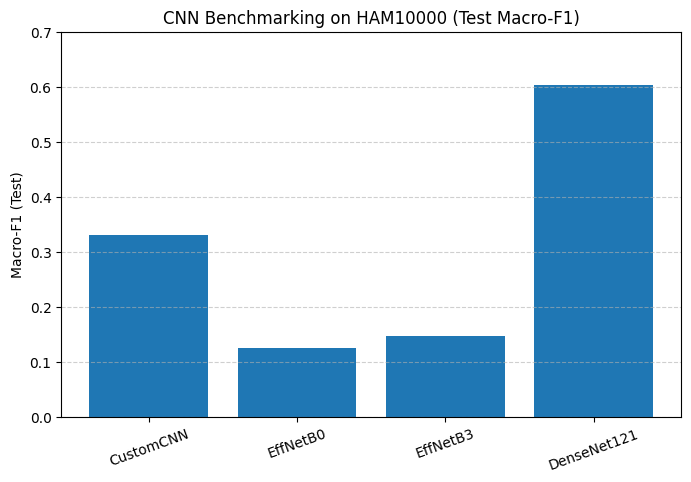

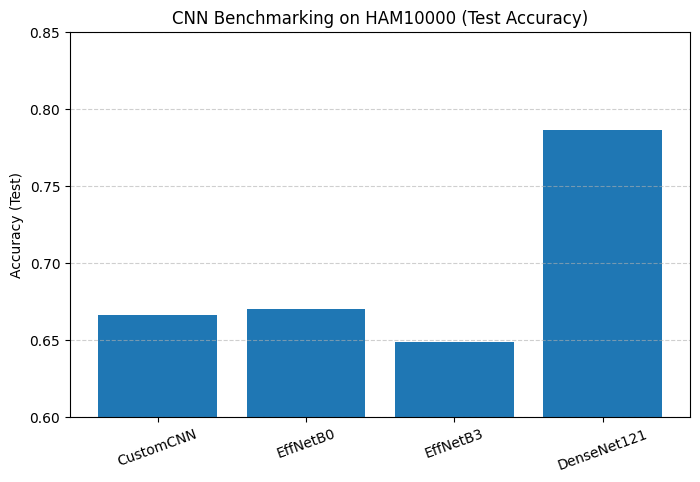

In [75]:
import matplotlib.pyplot as plt
import numpy as np

models = ["CustomCNN", "EffNetB0", "EffNetB3", "DenseNet121"]

test_acc = [0.6660, 0.6700, 0.6487, 0.7864]
test_f1  = [0.3314, 0.1242, 0.1476, 0.6029]

x = np.arange(len(models))

# --- Macro-F1 plot ---
plt.figure(figsize=(8,5))
plt.bar(x, test_f1)
plt.xticks(x, models, rotation=20)
plt.ylabel("Macro-F1 (Test)")
plt.title("CNN Benchmarking on HAM10000 (Test Macro-F1)")
plt.ylim(0, 0.7)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# --- Accuracy plot ---
plt.figure(figsize=(8,5))
plt.bar(x, test_acc)
plt.xticks(x, models, rotation=20)
plt.ylabel("Accuracy (Test)")
plt.title("CNN Benchmarking on HAM10000 (Test Accuracy)")
plt.ylim(0.6, 0.85)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Generalization Gap (Macro-F1)**

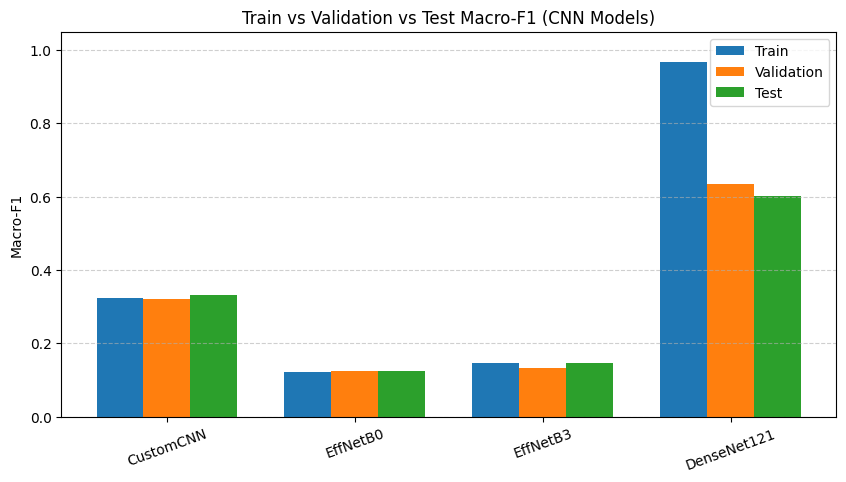

In [76]:
train_f1 = [0.3227, 0.1231, 0.1477, 0.9669]
val_f1   = [0.3214, 0.1252, 0.1319, 0.6346]
test_f1  = [0.3314, 0.1242, 0.1476, 0.6029]

x = np.arange(len(models))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, train_f1, width, label="Train")
plt.bar(x,         val_f1,   width, label="Validation")
plt.bar(x + width, test_f1,  width, label="Test")

plt.xticks(x, models, rotation=20)
plt.ylabel("Macro-F1")
plt.title("Train vs Validation vs Test Macro-F1 (CNN Models)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history, model_name):
    train_loss = history.history["loss"]
    val_loss   = history.history["val_loss"]
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} — Train vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
plot_loss(history_densenet, "DenseNet121")
plot_loss(history_effb0,    "EfficientNetB0")
plot_loss(history_effb3,    "EfficientNetB3")
plot_loss(history_custom,   "Custom CNN")


**Generalization Gap (Macro-F1)**

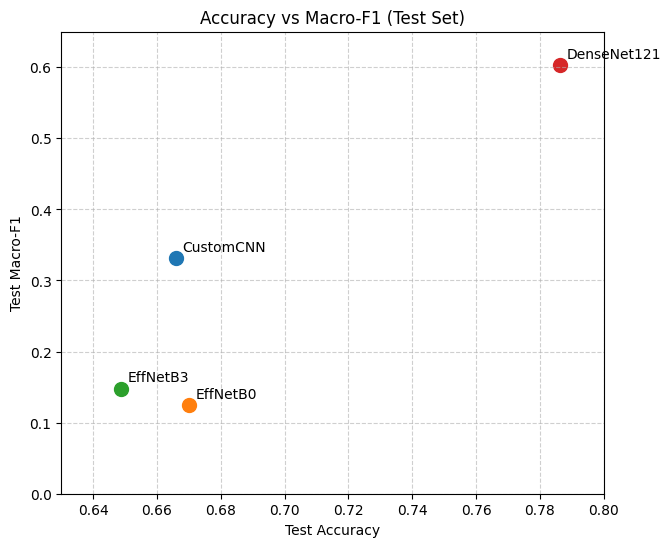

In [77]:
plt.figure(figsize=(7,6))

for i, model in enumerate(models):
    plt.scatter(test_acc[i], test_f1[i], s=100)
    plt.text(test_acc[i] + 0.002, test_f1[i] + 0.01, model)

plt.xlabel("Test Accuracy")
plt.ylabel("Test Macro-F1")
plt.title("Accuracy vs Macro-F1 (Test Set)")
plt.xlim(0.63, 0.80)
plt.ylim(0.0, 0.65)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


**DenseNet121 Class-wise Performance (Medical Relevance)**

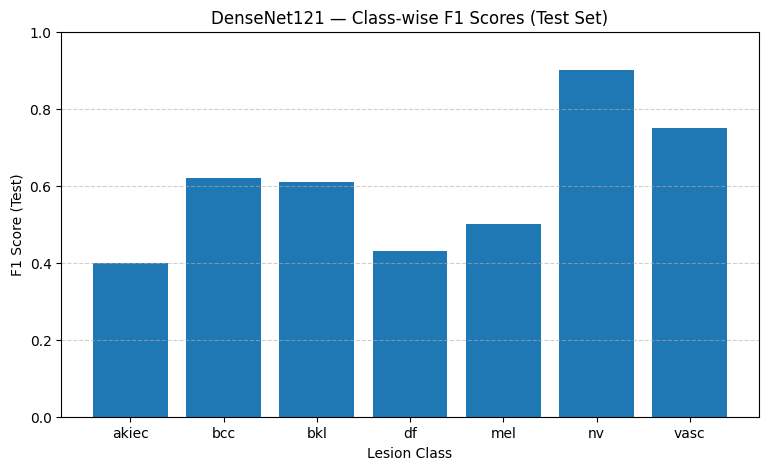

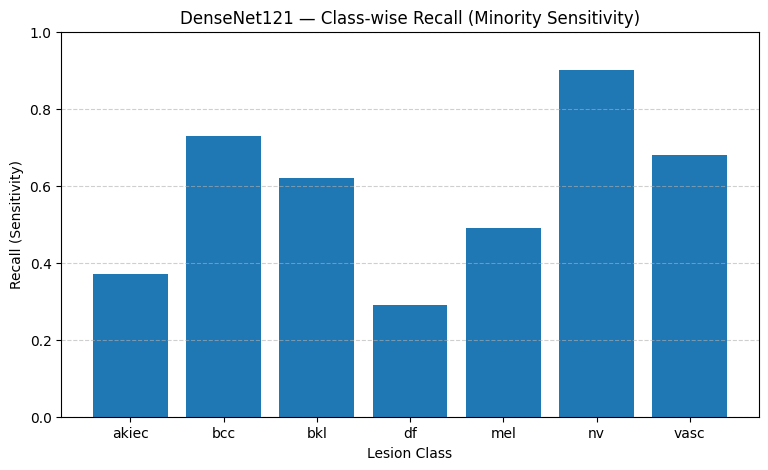

In [78]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

f1_scores = [
    0.40,  # akiec
    0.62,  # bcc
    0.61,  # bkl
    0.43,  # df
    0.50,  # mel
    0.90,  # nv
    0.75   # vasc
]

recall_scores = [
    0.37,  # akiec
    0.73,  # bcc
    0.62,  # bkl
    0.29,  # df
    0.49,  # mel
    0.90,  # nv
    0.68   # vasc
]
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))
plt.bar(classes, f1_scores)
plt.ylabel("F1 Score (Test)")
plt.xlabel("Lesion Class")
plt.title("DenseNet121 — Class-wise F1 Scores (Test Set)")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()
plt.figure(figsize=(9,5))
plt.bar(classes, recall_scores)
plt.ylabel("Recall (Sensitivity)")
plt.xlabel("Lesion Class")
plt.title("DenseNet121 — Class-wise Recall (Minority Sensitivity)")
plt.ylim(0, 1.0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**Final Model Comparison (Macro-F1)**

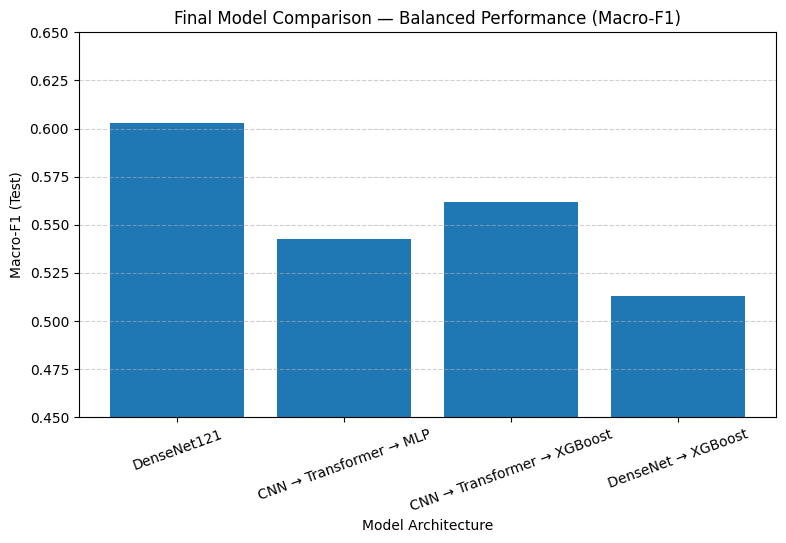

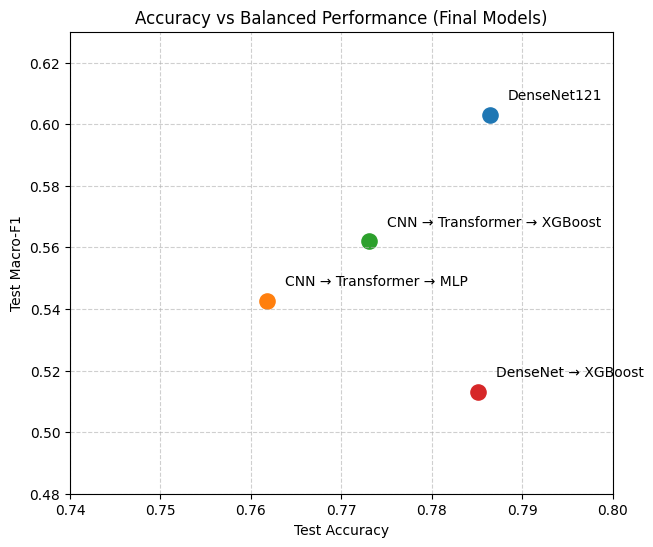

In [79]:
models = [
    "DenseNet121",
    "CNN → Transformer → MLP",
    "CNN → Transformer → XGBoost",
    "DenseNet → XGBoost"
]

macro_f1 = [
    0.6029,  # DenseNet121
    0.5427,  # CNN → Transformer → MLP
    0.5619,  # CNN → Transformer → XGBoost
    0.5131   # DenseNet → XGBoost
]
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,5))
plt.bar(models, macro_f1)
plt.ylabel("Macro-F1 (Test)")
plt.xlabel("Model Architecture")
plt.title("Final Model Comparison — Balanced Performance (Macro-F1)")
plt.ylim(0.45, 0.65)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.xticks(rotation=20)
plt.show()
test_acc = [
    0.7864,  # DenseNet121
    0.7618,  # CNN → Transformer → MLP
    0.7731,  # CNN → Transformer → XGBoost
    0.7851   # DenseNet → XGBoost
]

plt.figure(figsize=(7,6))

for i in range(len(models)):
    plt.scatter(test_acc[i], macro_f1[i], s=120)
    plt.text(test_acc[i] + 0.002, macro_f1[i] + 0.005, models[i])

plt.xlabel("Test Accuracy")
plt.ylabel("Test Macro-F1")
plt.title("Accuracy vs Balanced Performance (Final Models)")
plt.xlim(0.74, 0.80)
plt.ylim(0.48, 0.63)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
